In [88]:
import tensorflow as tf
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import torch
import zipfile

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
from google.colab import files
from google.colab import drive

# Cargar datos

In [89]:
# Crear Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
# Definir rutas
train_path = '/content/drive/MyDrive/dogs-vs-cats/dogs-vs-cats/train'
cats_path = os.path.join(train_path, 'cats')
dogs_path = os.path.join(train_path, 'dogs')

In [91]:
# Crear carpetas destino
os.makedirs(cats_path, exist_ok=True)
os.makedirs(dogs_path, exist_ok=True)

In [92]:
# Ruta del archivo
ruta_fichero = '/content/drive/MyDrive/dogs-vs-cats/dogs-vs-cats/train'

In [93]:
# Mover imágenes según el nombre
for filename in os.listdir(ruta_fichero):
    if filename.startswith('cat') and filename.endswith('.jpg'):
        shutil.move(os.path.join(ruta_fichero, filename), os.path.join(cats_path, filename))
    elif filename.startswith('dog') and filename.endswith('.jpg'):
        shutil.move(os.path.join(ruta_fichero, filename), os.path.join(dogs_path, filename))

# Procesamiento de imágenes

In [94]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

trdata = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

tsdata = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Entrenamiento:", trdata.samples)
print("Validación:", tsdata.samples)

Found 1500 images belonging to 2 classes.
Found 374 images belonging to 2 classes.
Entrenamiento: 1500
Validación: 374


# Construcción del modelo CNN

In [95]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(224,224,3)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [96]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con callbacks

In [98]:
# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [99]:
# Entrenamiento
history = model.fit(
    trdata,
    validation_data=tsdata,
    epochs=20,
    callbacks=[checkpoint, earlystop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.4764 - loss: 0.7782

47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 989ms/step - accuracy: 0.4767 - loss: 0.7771 - val_accuracy: 0.5080 - val_loss: 0.6931
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 542ms/step - accuracy: 0.4840 - loss: 0.6935 - val_accuracy: 0.5080 - val_loss: 0.6931
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 556ms/step - accuracy: 0.5150 - loss: 0.6929 - val_accuracy: 0.5080 - val_loss: 0.6930
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 540ms/step - accuracy: 0.5149 - loss: 0.6928 - val_accuracy: 0.5080 - val_loss: 0.6930
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 538ms/step - accuracy: 0.4924 - loss: 0.6936 - val_accuracy: 0.5080 - val_loss: 0.6930
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 532ms/step - accuracy: 0.5148 - loss: 0.6929 - val_accuracy: 0.5080 - val_loss: 0.6930
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 26s 546ms/step - accuracy: 0.5082 - loss: 0.6931 - val_accuracy: 0.5080 - val_loss: 0.6930
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 534ms/step - accuracy: 0.5150 - loss: 0.6929 - val_accuracy: 0.508

# Visualizar rendimiento

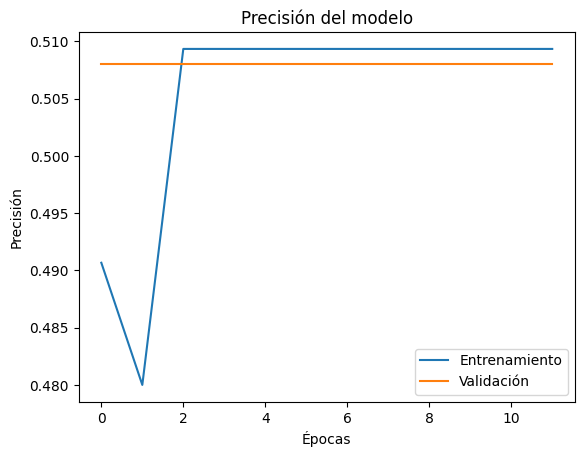

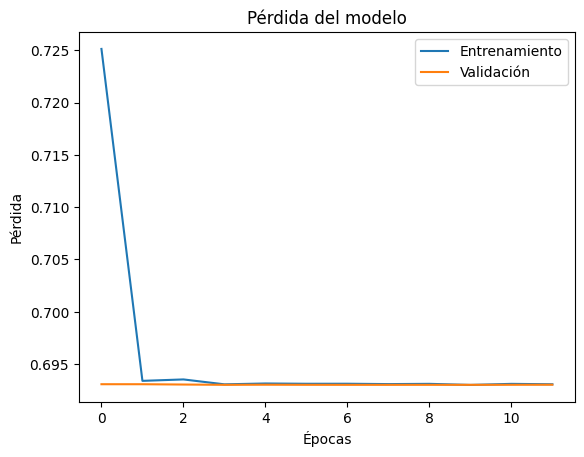

In [100]:
# Precisión
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Guardar el modelo final

In [101]:
model.save('/content/drive/MyDrive/dogs-vs-cats/modelo_final.h5')